In [73]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def fit_polynomial_trend(train_data, order=1):
    y = train_data["Ocupados"]
    x = np.linspace(1, train_data.shape[0], train_data.shape[0])
    
    # Generar las potencias necesarias según el orden
    X_powers = np.column_stack([x**i for i in range(1, order+1)])
    X = sm.add_constant(X_powers)
    pol = sm.OLS(y, X)
    pol_trend = pol.fit()

    return pol_trend

def forecast_and_plot(model, train_data, test_data, order, forecast_horizon=6):
    x_for = np.linspace(train_data.shape[0] + 1, train_data.shape[0] + forecast_horizon, forecast_horizon)
    X_for = sm.add_constant(np.column_stack([x_for**i for i in range(1, order+1)]))

    dt = model.get_prediction(X_for).summary_frame(alpha=0.05)
    y_prd = dt['mean']
    yprd_ci_lower = dt['obs_ci_lower']
    yprd_ci_upper = dt['obs_ci_upper']
    preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
    preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

    # Plotting
    #fig, ax = plt.subplots(figsize=(12, 6))
    #ax.plot(train_data["Ocupados"], label="Datos Entrenamiento")
    #ax.plot(x_for, preds['Point_forecast'], label=f"Tendencia Polinómica (Orden {order})")
    #ax.fill_between(x_for, preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
    #ax.legend()
    #plt.show()

    # Evaluación del modelo con conjunto de prueba
    y_test = test_data["Ocupados"]
    y_test.index = range(len(y_test))

    mape_result_direct = ((np.abs(y_test - y_prd) / np.abs(y_test))
                          .replace([np.inf, -np.inf], np.nan)
                          .mean() * 100)
    r2_ma = r2_score(y_test, y_prd)
    print(f"MAPE : {mape_result_direct}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_prd))}")
    print(f"Coef. R2 : {r2_ma}")

    return preds


In [74]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subplots(y_data, fitted_values, x_data, y_train, point_forecast, lower_95=None, upper_95=None):
    """
    Crea una figura con subplots.

    Parameters:
    - y_data: Datos para la gráfica 1 (Tasa ocupados mensual)
    - fitted_values: Datos ajustados para la gráfica 1 (Tendencia Cubica)
    - x_data: Datos para la gráfica 2 (Datos Entrenamiento)
    - y_train: Datos ajustados para la gráfica 2 (Tendencia Cubica)
    - point_forecast: Punto de pronóstico para la gráfica 2
    - lower_95: Límite inferior para el relleno entre líneas en la gráfica 2 (opcional)
    - upper_95: Límite superior para el relleno entre líneas en la gráfica 2 (opcional)
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfica 1
    axs[0].plot(y_data, label="Tasa ocupados mensual")
    axs[0].plot(fitted_values, label="Tendencia Cubica")
    axs[0].legend()
    axs[0].grid()

    # Gráfica 2
    axs[1].plot(x_data, y_data, label="Datos Entrenamiento")
    axs[1].plot(x_data, y_train, label="Tendencia Cubica")
    
    # Añadir relleno entre líneas si lower_95 y upper_95 están disponibles
    if lower_95 is not None and upper_95 is not None:
        axs[1].fill_between(x_data, lower_95, upper_95, color='blue', alpha=0.1)

    axs[1].legend()

    # Ajustar el diseño para evitar solapamiento
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

# Ejemplo de uso
# plot_subplots(y, pol_3.fittedvalues, x, y, preds['Point_forecast'], lower_95, upper_95)


In [75]:
url = 'https://github.com/carlosjara/MCD_FAII/blob/main/RECURSOS/content/datosEmpleo.xlsx?raw=true'
#data = pd.read_excel("content/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data = pd.read_excel(url,index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [76]:
## Dummies
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
#print(season.summary())
data_dummie = pd.concat([X, y], axis=1)

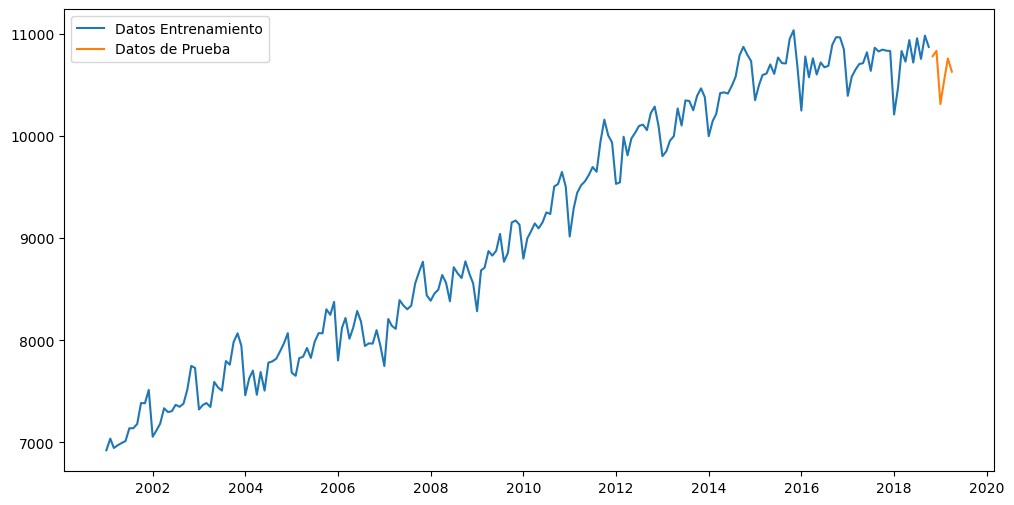

In [77]:
train_len = 214
train_td = data_dummie[["Ocupados"]][:train_len]
test_td = data_dummie[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [80]:
with open('config.yaml', 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)

# Aplicar la función de ajuste y pronóstico para la tendencia lineal
print("orden: ",config['lineal']['order'])
linear_model = fit_polynomial_trend(train_td, order=config['lineal']['order'])
linear_preds = forecast_and_plot(linear_model, train_td, test_td, order=config['lineal']['order'])

# Aplicar la función de ajuste y pronóstico para la tendencia cuadrática
print("orden: ",config['cuadratica']['order'])
quadratic_model = fit_polynomial_trend(train_td, order=config['cuadratica']['order'])
quadratic_preds = forecast_and_plot(quadratic_model, train_td, test_td, order=config['cuadratica']['order'])


# Aplicar la función de ajuste y pronóstico para la tendencia cuadrática

print("orden: ",config['cubica']['order'])
quadratic_model = fit_polynomial_trend(train_td, order=config['cubica']['order'])
quadratic_preds = forecast_and_plot(quadratic_model, train_td, test_td, order=config['cubica']['order'])



# Aplicar la función de ajuste y pronóstico para la tendencia cuadrática

print("orden: ",config['orden5']['order'])
quadratic_model = fit_polynomial_trend(train_td, order=config['orden5']['order'])
quadratic_preds = forecast_and_plot(quadratic_model, train_td, test_td, order=config['orden5']['order'])



# Aplicar la función de ajuste y pronóstico para la tendencia cuadrática

print("orden: ",config['orden8']['order'])
quadratic_model = fit_polynomial_trend(train_td, order=config['orden8']['order'])
quadratic_preds = forecast_and_plot(quadratic_model, train_td, test_td, order=config['orden8']['order'])



orden:  1
MAPE : 6.549713840156239
RMSE : 718.651675100173
Coef. R2 : -15.680359850063919
orden:  2
MAPE : 5.849433933383171
RMSE : 646.5978131678402
Coef. R2 : -12.503209138154073
orden:  3
MAPE : 1.6076957260938436
RMSE : 238.46910836431258
Coef. R2 : -0.8366769973633021
orden:  5
MAPE : 1.4696355217723824
RMSE : 219.94549378126754
Coef. R2 : -0.5624231616717983
orden:  6
MAPE : 2.6046297241278342
RMSE : 332.0337745414395
Coef. R2 : -2.5606809093080214
